In [1]:
import keras 
import tensorflow as tf

In [2]:
from keras.datasets import mnist
from keras.models import Sequential 
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#x, y= mnist.load_data()
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [4]:
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():
   noise_shape = (100,) #1D array of size 100 (latent vector / noise)
  #Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

   model = Sequential()

   #model.add(Flatten(input_shape=noise_shape))
   model.add(Dense(256, input_shape=noise_shape))
   model.add(LeakyReLU(alpha=0.2))
   model.add(BatchNormalization(momentum=0.8))
   model.add(Dense(512))
   model.add(LeakyReLU(alpha=0.2))
   model.add(BatchNormalization(momentum=0.8))
   model.add(Dense(1024))
   model.add(LeakyReLU(alpha=0.2))
   model.add(BatchNormalization(momentum=0.8))
    
   model.add(Dense(np.prod(img_shape), activation='tanh'))
   model.add(Reshape(img_shape))

   model.summary()

   noise = Input(shape=noise_shape)
   img = model(noise)    #Generated image
  # plt.imshow (img) 
   #plt.show ()  

   return Model(noise, img)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################


In [5]:
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img) #prob of fake or real

    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.


In [6]:
#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=500):

    # Load the dataset (real imagees)
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)

In [7]:
#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=500):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)


#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))#half batch number of vectors with each size of 100 (noise value)

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size
        #print (valid_y)
        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)


In [8]:
#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view

In [9]:
#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)
#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image
#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=10000, batch_size=32, save_interval=2000)

Streaming output truncated to the last 5000 lines.
7500 [D loss: 0.766878, acc.: 46.88%] [G loss: 0.884656]
1/1 [==============================] - 0s 17ms/step
7501 [D loss: 0.723281, acc.: 46.88%] [G loss: 0.865377]
1/1 [==============================] - 0s 17ms/step
7502 [D loss: 0.648103, acc.: 56.25%] [G loss: 0.879612]
1/1 [==============================] - 0s 17ms/step
7503 [D loss: 0.659241, acc.: 53.12%] [G loss: 0.901576]
1/1 [==============================] - 0s 19ms/step
7504 [D loss: 0.772465, acc.: 46.88%] [G loss: 0.856657]
1/1 [==============================] - 0s 18ms/step
7505 [D loss: 0.657264, acc.: 56.25%] [G loss: 0.852763]
1/1 [==============================] - 0s 25ms/step
7506 [D loss: 0.706693, acc.: 71.88%] [G loss: 0.868323]
1/1 [==============================] - 0s 25ms/step
7507 [D loss: 0.604982, acc.: 71.88%] [G loss: 0.863575]
1/1 [==============================] - 0s 17ms/step
7508 [D loss: 0.673332, acc.: 53.12%] [G loss: 0.833499]
1/1 [===============

In [10]:
#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.

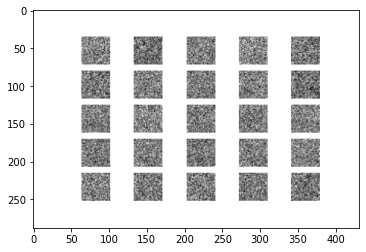

In [11]:
import matplotlib.image as mpimg
img=mpimg.imread ("/content/mnist_0.png")
plt.imshow(img)